In [47]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#for image processing
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score


import matplotlib.pyplot as plt
%matplotlib inline

train_dir = "../input/train/train"
test_dir = "../input/test/test"

In [48]:

#training df import
df = pd.read_csv("../input/train.csv")
print(df.shape) #we have quite a bit of data, not too little.
#The dataset isn't balanced, yet it's not too heavily leaning toward 1 class or the other. A normal CNN could still have
#a decent result with this set, assuming that the differences will be distinct enough.
print(df.has_cactus.value_counts(normalize=True))
df.head()

(17500, 2)
1    0.750629
0    0.249371
Name: has_cactus, dtype: float64


,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [49]:
#create a list to hold the 4d image tensors data. Note: the order of training images and df's labels are identical.
def load_imgs(train_dir,df):
    img_lst = []
    for img in df["id"]:
        with open(os.path.join(train_dir, img), 'rb') as i:
            img = image.load_img(i,target_size=(32,32))
            img = image.img_to_array(img)/255.0 #normalization
            img_lst.append(image.img_to_array(img))
    return img_lst


#return random indices from a df, particularly use to see random images
def random_imgs(df,num_images,train):
    index_lst = df["id"].sample(n=num_images).index
    img_lst = []
    for i in index_lst:
        img_lst.append(train[i])
    return img_lst

#only plot 2x2 images. Helper function. One can always generalize the function if neccessary
def plot_examples(img_lst,title):
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(8,8))
    ax[0].imshow(img_lst[0])
    ax[0].set_title(title)
    ax[1].imshow(img_lst[1])
    #ax[1].set_title(title)
    ax[2].imshow(img_lst[2])
    #ax[2].set_title(title)
    ax[3].imshow(img_lst[3])
    #ax[3].set_title(title)
    plt.show()


In [50]:
#loading training data
train = load_imgs(train_dir,df)
print(np.shape(train))

(17500, 32, 32, 3)


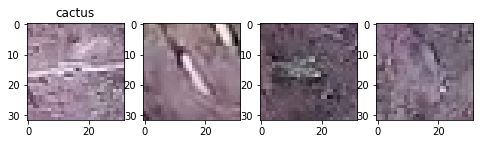

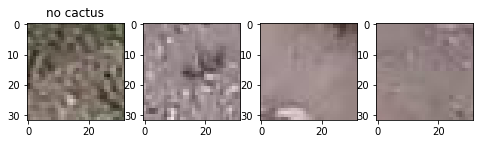

In [51]:
#to pick random images for viewring from both labels (cactus, no cactus)
cactus = random_imgs(df[df["has_cactus"]==1],4,train)
no_cactus = random_imgs(df[df["has_cactus"] == 0],4,train)
plot_examples(cactus,"cactus")
plot_examples(no_cactus,"no cactus")

Looks like we can barely distinguish the differences. What I can notice is that generally, cactuses have a long, whitish features coming out. This will be interesting, as we human already have a hard time distinguishing cactuses and long, rod-like objects in the images.

In [52]:
from sklearn.model_selection import train_test_split
#since we have the target and the imported tensors in order, it's quite easy for us to split our data.
#also, with the number of data we have, it's not too low such that we'll be utilising the k-fold val.

def train_val_split(train,df):
    #keeping random_state for consistency with future models for comparison
    X_train, X_val, y_train, y_val = train_test_split(train,df["has_cactus"], test_size=0.3,stratify=df["has_cactus"],random_state=1)
    return np.array(X_train), np.array(X_val), np.array(y_train), np.array(y_val)

X_train, X_val, y_train, y_val = train_val_split(train,df)

In [53]:

#we'll be using keras for prototyping first
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator #image augmentation
from keras import callbacks

history = callbacks.History() #need to be defined first

In [54]:
#using functional API
from keras import Input, layers, Model

#to combat overfitting, better optimization for CNN, we'll be using Batch normalization PRIOR to activation.
#There has been a debate on where to use it, but the consensus has been to use it prior/after non-linearity
def train_cnn():
    input_tensor = Input(shape=(32,32,3,)) #our image dimension. Unknown sample size input
    conv1 = layers.Conv2D(filters=9,kernel_size=(3,3))(input_tensor)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Activation("relu")(conv1)
    pool1 = layers.MaxPool2D(pool_size=(2,2),padding="SAME")(conv1)

    conv2 = layers.Conv2D(filters=17,kernel_size=(3,3))(pool1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Activation("relu")(conv2)
    pool2 = layers.MaxPool2D(pool_size=(2,2),padding="SAME")(conv2)

    conv3 = layers.Conv2D(filters=31,kernel_size=(3,3))(pool2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Activation("relu")(conv3)
    pool3 = layers.MaxPool2D(pool_size=(2,2),padding="SAME")(conv3)

    flat = layers.Flatten()(pool3)
    flat = layers.Dropout(rate=0.3)(flat) #for hidden layer
    hidden = layers.Dense(units=500,activation="relu")(flat)
    output_tensor = layers.Dense(units=1,activation="sigmoid")(hidden)

    model = Model(inputs=input_tensor, outputs=output_tensor)
    model.compile(optimizer=optimizers.rmsprop(lr=0.0001), loss="binary_crossentropy",metrics=["accuracy"])
    print(model.summary())
    
    return model

In [55]:
model1 = train_cnn()
history1 = model1.fit(X_train,y_train,validation_data=(X_val,y_val),
                      verbose=True,shuffle=True,epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 30, 30, 9)         252       
_________________________________________________________________
batch_normalization_10 (Batc (None, 30, 30, 9)         36        
_________________________________________________________________
activation_12 (Activation)   (None, 30, 30, 9)         0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 15, 15, 9)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 13, 13, 17)        1394      
_________________________________________________________________
batch_normalization_11 (Batc (None, 13, 13, 17)        68        
__________

12250/12250 [==============================] - 3s 243us/step - loss: 0.0266 - acc: 0.9903 - val_loss: 0.0440 - val_acc: 0.9882
Epoch 42/50
12250/12250 [==============================] - 3s 241us/step - loss: 0.0202 - acc: 0.9925 - val_loss: 0.0486 - val_acc: 0.9872
Epoch 43/50
12250/12250 [==============================] - 3s 242us/step - loss: 0.0231 - acc: 0.9918 - val_loss: 0.0517 - val_acc: 0.9870
Epoch 44/50
12250/12250 [==============================] - 3s 245us/step - loss: 0.0206 - acc: 0.9927 - val_loss: 0.0532 - val_acc: 0.9857
Epoch 45/50
12250/12250 [==============================] - 3s 246us/step - loss: 0.0214 - acc: 0.9929 - val_loss: 0.0485 - val_acc: 0.9882
Epoch 46/50
12250/12250 [==============================] - 3s 241us/step - loss: 0.0238 - acc: 0.9921 - val_loss: 0.0488 - val_acc: 0.9878
Epoch 47/50
12250/12250 [==============================] - 3s 240us/step - loss: 0.0191 - acc: 0.9930 - val_loss: 0.0467 - val_acc: 0.9888
Epoch 48/50
12250/12250 [==============

In [56]:
def model_plot(history,epochs,title,y_range=[0.8,1.0],save=0 ):
    train_losses = history.history["loss"]
    val_losses = history.history["val_loss"]
    plt.plot([i for i in range(0,epochs)],train_losses,val_losses)
    plt.legend(["Train Loss","Val Loss"])
    plt.title(title)
    
    if save == 1:
        plt.savefig(title+"_Losses.jpg",dpi=1000)
    plt.show()
    
    
    train_losses = history.history["acc"]
    val_losses = history.history["val_acc"]
    plt.plot([i for i in range(0,epochs)],train_losses,val_losses)
    plt.legend(["Train_acc","Val_acc"])
    plt.title(title)
    plt.ylim(y_range)
    
    if save == 1:
        plt.savefig(title+"_Accuracy.jpg")
    plt.show()

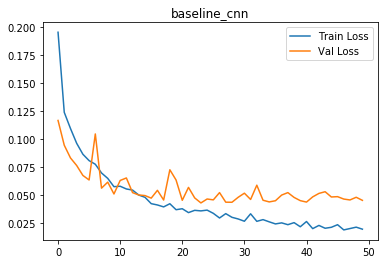

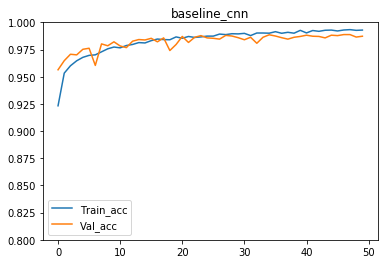

In [57]:
#uncomment for plotting
model_plot(history1,epochs=50,title="baseline_cnn")

It seems that from a baseline cnn point of view, we're pretty close to be able to identify most of these images. Based on our view of the images earlier, it is probably because cactuses have long, rod-like structures at a certain channels. This will be hard to be improved upon. Let's see what else can we do.

### CNN with Augmentation

A known method to help reduced overfitting with limited data is to use a technique called image augmentation. However, we have around 17.5k training data(reduced by how much we split our train/val set). It is not 

In [58]:

#Data Augmentation. Generating additional data for training
#refer to Keras for extra documentation as well as
#https://machinelearningmastery.com/image-augmentation-deep-learning-keras/ for a brief introduction
def data_aug(X_train):
    datagen = ImageDataGenerator(
        rotation_range=20,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        width_shift_range=0.15,
        height_shift_range=0.15)
    
    datagen.fit(X_train)
    # fits the model on batches with real-time data augmentation:
    return datagen

datagen = data_aug(X_train)

In [59]:
model2 = train_cnn()
history2 = model2.fit_generator(datagen.flow(np.array(X_train),np.array(y_train),batch_size=30),
                              validation_data= (np.array(X_val),np.array(y_val)),
                              steps_per_epoch=len(X_train) / 50,epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 30, 30, 9)         252       
_________________________________________________________________
batch_normalization_13 (Batc (None, 30, 30, 9)         36        
_________________________________________________________________
activation_15 (Activation)   (None, 30, 30, 9)         0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 15, 15, 9)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 13, 13, 17)        1394      
_________________________________________________________________
batch_normalization_14 (Batc (None, 13, 13, 17)        68        
__________

Epoch 43/50
245/245 [==============================] - 5s 19ms/step - loss: 0.0662 - acc: 0.9770 - val_loss: 0.0411 - val_acc: 0.9880
Epoch 44/50
245/245 [==============================] - 5s 19ms/step - loss: 0.0632 - acc: 0.9773 - val_loss: 0.0412 - val_acc: 0.9880
Epoch 45/50
245/245 [==============================] - 5s 19ms/step - loss: 0.0604 - acc: 0.9795 - val_loss: 0.0663 - val_acc: 0.9813
Epoch 46/50
245/245 [==============================] - 5s 19ms/step - loss: 0.0560 - acc: 0.9782 - val_loss: 0.0593 - val_acc: 0.9842
Epoch 47/50
245/245 [==============================] - 5s 19ms/step - loss: 0.0592 - acc: 0.9805 - val_loss: 0.4525 - val_acc: 0.8950
Epoch 48/50
245/245 [==============================] - 5s 19ms/step - loss: 0.0581 - acc: 0.9771 - val_loss: 0.1009 - val_acc: 0.9682
Epoch 49/50
245/245 [==============================] - 5s 19ms/step - loss: 0.0600 - acc: 0.9782 - val_loss: 0.0399 - val_acc: 0.9870
Epoch 50/50
245/245 [==============================] - 5s 19ms

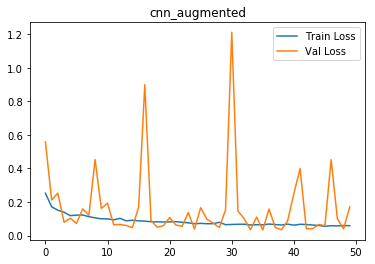

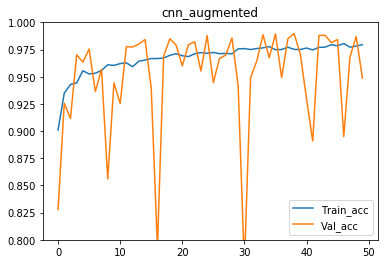

In [60]:
#uncomment for plotting
model_plot(history2,epochs=50,title="cnn_augmented")

What have we learned ? Image augmentation didn't proved to be helpful in our search for better optimization. The slight overfitting problem seems to be solved, but we are facing an optimization issue. It might be because our images are very small, and the details of our structure might not be good enough to handle all the augmentations. Least of all, we humans also have a hard time viewing the cactuses well on images.

Other things to try to improve further: inception network, VGG pre-trained network, tensorboard visualization

### VGG Pre-trained Model - Transfer Learning

In [61]:
from keras.applications import VGG16

#refer to: https://keras.io/applications/#vgg16
#we just take the conv base and frozen it, since it should help with broad classification
conv_base = VGG16(weights='imagenet',include_top=False, input_shape=(32,32,3))
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

In [62]:
#shouldn't we do a baseline prediction with the VGG16 pre-trained network by itself first?
conv_base.trainable=False #we don't want to touch the generality of our VGG16
#encapsulating for later usage
def vgg_layer(conv_base):
    conv_base.trainable=False
    model3 = Sequential()
    model3.add(conv_base) #output = 512 as in summary above, treat as a "layer".
    model3.add(Flatten())
    model3.add(Dense(400))
    
    #tested these out already
    #model3.add(Activation("relu"))
    #model3.add(Dropout(rate=0.3))
    #model3.add(Dense(1,activation="sigmoid")) #output
    return model3


In [63]:
input_tensor = Input(shape=(32,32,3)) #similar to train_cnn() defined above
vgg = vgg_layer(conv_base)(input_tensor)
activation = layers.Activation("relu")(vgg)
dropout = layers.Dropout(rate=0.3)(activation)
output_tensor = layers.Dense(1, activation="sigmoid")(dropout)

model3 = Model(inputs=input_tensor,outputs=output_tensor)
model3.compile(optimizer=optimizers.rmsprop(lr=0.0001), loss="binary_crossentropy",metrics=["accuracy"])

In [64]:
history3 = model3.fit(X_train,y_train,validation_data=(X_val,y_val),batch_size=30,
                      verbose=True,shuffle=True,epochs=50)

Train on 12250 samples, validate on 5250 samples
Epoch 1/50
12250/12250 [==============================] - 6s 471us/step - loss: 0.2968 - acc: 0.8833 - val_loss: 0.1846 - val_acc: 0.9440
Epoch 2/50
12250/12250 [==============================] - 5s 372us/step - loss: 0.1608 - acc: 0.9444 - val_loss: 0.1398 - val_acc: 0.9568
Epoch 3/50
12250/12250 [==============================] - 5s 376us/step - loss: 0.1321 - acc: 0.9539 - val_loss: 0.1247 - val_acc: 0.9587
Epoch 4/50
12250/12250 [==============================] - 5s 387us/step - loss: 0.1187 - acc: 0.9577 - val_loss: 0.1173 - val_acc: 0.9608
Epoch 5/50
12250/12250 [==============================] - 5s 383us/step - loss: 0.1112 - acc: 0.9598 - val_loss: 0.1123 - val_acc: 0.9611
Epoch 6/50
12250/12250 [==============================] - 5s 390us/step - loss: 0.1056 - acc: 0.9620 - val_loss: 0.1100 - val_acc: 0.9632
Epoch 7/50
12250/12250 [==============================] - 5s 388us/step - loss: 0.0986 - acc: 0.9646 - val_loss: 0.1061 - v

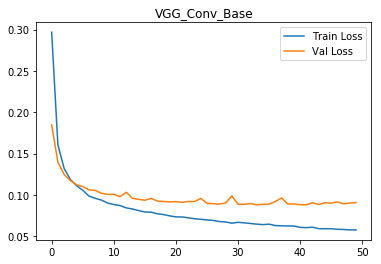

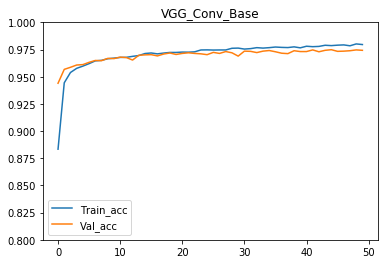

In [65]:
model_plot(history3,epochs=50,title="VGG_Conv_Base")

Our VGG pre-trained network is as good as the normal CNN network (which is quite impressive, seeing how VGG is mainly used for broader classification, not application specific). Seems like they don't lack images of cactuses. What happen if we can base off the idea of inception network/residue network, in which we'll use the strength of VGG for broad based classification and the 1st CNN for a more specific details. Afterward, we'll add up the output for a final classification.

### Final Model

In [66]:
#there are other inception models and there are pre-made versions in Keras, but we can create one ourselves here using VGG + the first model.
#the output of VGG is 512 (flattened). It's what we had defined in the vgg_layer() function above.
def inception_cnn():
    input_tensor = Input(shape=(32,32,3,)) #our image dimension. Unknown sample size input
    conv1 = layers.Conv2D(filters=9,kernel_size=(3,3))(input_tensor)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Activation("relu")(conv1)
    pool1 = layers.MaxPool2D(pool_size=(2,2),padding="SAME")(conv1)

    conv2 = layers.Conv2D(filters=17,kernel_size=(3,3))(pool1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Activation("relu")(conv2)
    pool2 = layers.MaxPool2D(pool_size=(2,2),padding="SAME")(conv2)

    conv3 = layers.Conv2D(filters=31,kernel_size=(3,3))(pool2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Activation("relu")(conv3)
    pool3 = layers.MaxPool2D(pool_size=(2,2),padding="SAME")(conv3)

    flat = layers.Flatten()(pool3)
    flat = layers.Dropout(rate=0.3)(flat) #for hidden layer
    hidden = layers.Dense(units=500)(flat)
    
    #VGG16 up to the dense layer
    vgg = vgg_layer(conv_base)(input_tensor)
    
    
    #a combination of our own cnn + vgg + 450 dense with lr=0.0001 brought the accuracy up to low ~0.99.
    #let's see if re-using the original input will help with the vanishing gradient problem, and overfitting.
    #we'll be using depthwise separable convolution, point-wise convolution of 1x1/mixing channels while not touching the spatial aspect (conv)
    #https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728
    
    separable  = layers.SeparableConv2D(filters=11,kernel_size=(1,1),activation="relu")(input_tensor)
    pool_separable = layers.MaxPool2D(pool_size=(2,2),padding="SAME")(separable)
    flat_separable = layers.Flatten()(pool_separable)
    
    #hidden is the original cnn dense layer, vgg is the vgg's dense layer. Combining the input for better details/broad analysis
    combined = layers.concatenate([hidden,vgg,flat_separable],axis=-1) #list input
    final_dense = layers.Dense(450)(combined)
    activation = layers.Activation("relu")(final_dense)
    dropout = layers.Dropout(rate=0.25)(activation)
    output_tensor = layers.Dense(1, activation="sigmoid")(dropout)
    
    
    model = Model(inputs=input_tensor, outputs=output_tensor)
    print(model.summary())
    model.compile(optimizer=optimizers.rmsprop(lr=0.0001), loss="binary_crossentropy",metrics=["accuracy"])
    print(model.summary())
    return model

In [67]:
model4 = inception_cnn()
history4 = model4.fit(X_train,y_train,validation_data=(X_val,y_val),batch_size=30,
                      verbose=True,shuffle=True,epochs=50)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 30, 30, 9)    252         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 30, 30, 9)    36          conv2d_16[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 30, 30, 9)    0           batch_normalization_16[0][0]     
__________________________________________________________________________________________________
max_poolin

Train on 12250 samples, validate on 5250 samples
Epoch 1/50
12250/12250 [==============================] - 8s 672us/step - loss: 0.1053 - acc: 0.9611 - val_loss: 0.0538 - val_acc: 0.9836
Epoch 2/50
12250/12250 [==============================] - 6s 507us/step - loss: 0.0486 - acc: 0.9833 - val_loss: 0.0475 - val_acc: 0.9834
Epoch 3/50
12250/12250 [==============================] - 6s 507us/step - loss: 0.0390 - acc: 0.9866 - val_loss: 0.0412 - val_acc: 0.9878
Epoch 4/50
12250/12250 [==============================] - 6s 509us/step - loss: 0.0336 - acc: 0.9888 - val_loss: 0.0487 - val_acc: 0.9842
Epoch 5/50
12250/12250 [==============================] - 6s 512us/step - loss: 0.0293 - acc: 0.9900 - val_loss: 0.0439 - val_acc: 0.9876
Epoch 6/50
12250/12250 [==============================] - 7s 536us/step - loss: 0.0260 - acc: 0.9909 - val_loss: 0.0428 - val_acc: 0.9872
Epoch 7/50
12250/12250 [==============================] - 6s 528us/step - loss: 0.0238 - acc: 0.9922 - val_loss: 0.0385 - v

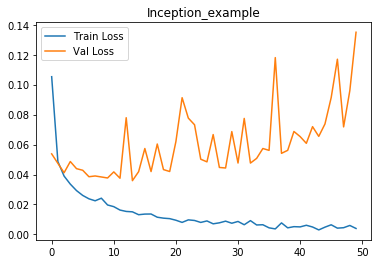

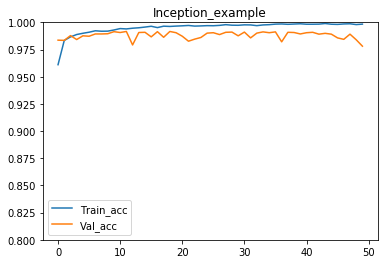

In [68]:
model_plot(history4,epochs=50,title="Inception_example")

In [69]:
model1.save_weights("model1.h5",overwrite=False)
model2.save_weights("model2.h5",overwrite=False)
model3.save_weights("model3.h5",overwrite=False)
model4.save_weights("model4.h5",overwrite=False)

[WARNING] model1.h5 already exists - overwrite? [y/n]y
[TIP] Next time specify overwrite=True!
[WARNING] model2.h5 already exists - overwrite? [y/n]y
[TIP] Next time specify overwrite=True!
[WARNING] model3.h5 already exists - overwrite? [y/n]y
[TIP] Next time specify overwrite=True!
[WARNING] model4.h5 already exists - overwrite? [y/n]y
[TIP] Next time specify overwrite=True!


As one can see, after about 10 epochs, the loss of validation set has stopped going down. We are proceeding to overfit a little afterward. Sometimes, it is unavoidable given the sensitivity of our dataset. Is it possible to improve the benchmark even further ? Probably. Is it worth it over the original CNN model ? Maybe. Keep in mind that each time we are benchmarking using validation data, we are essentially overfitting to the "validation" set a little bit. Sometimes, that can prove to be a setback on the real test set.

> ### TensorBoard (Personal)

In [70]:
from keras.callbacks import ModelCheckpoint,TensorBoard 
import tensorflow as tf

In [71]:
#you may need to install the h5py library to output network weights in HDF5 format.
#refer to: https://machinelearningmastery.com/check-point-deep-learning-models-keras/ for information on how to use checkpoint (personal)

filepath = "best_weight.hdf5" #model checkpoints will be saved with the epoch number and the validation accuracy in the filename.
checkpointer = ModelCheckpoint(filepath=filepath,monitor="val_acc", verbose=1, save_best_only=True,save_weights_only=False,mode="max",period=1) #max because we want max accuracy

my_log_dir = "./logs"
tensorboard = TensorBoard(log_dir=my_log_dir, histogram_freq=0, batch_size=30, write_graph=True) #just need the architecture

history4 = model4.fit(X_train,y_train,validation_data=(X_val,y_val),batch_size=30,callbacks=[checkpointer,tensorboard],
                      verbose=True,shuffle=True,epochs=20)

Train on 12250 samples, validate on 5250 samples
Epoch 1/10
12250/12250 [==============================] - 6s 510us/step - loss: 0.0041 - acc: 0.9989 - val_loss: 0.0728 - val_acc: 0.9890

Epoch 00001: val_acc improved from -inf to 0.98895, saving model to best_weight.hdf5
Epoch 2/10
12250/12250 [==============================] - 6s 515us/step - loss: 0.0045 - acc: 0.9984 - val_loss: 0.0563 - val_acc: 0.9907

Epoch 00002: val_acc improved from 0.98895 to 0.99067, saving model to best_weight.hdf5
Epoch 3/10
12250/12250 [==============================] - 6s 513us/step - loss: 0.0035 - acc: 0.9986 - val_loss: 0.0758 - val_acc: 0.9891

Epoch 00003: val_acc did not improve from 0.99067
Epoch 4/10
12250/12250 [==============================] - 7s 541us/step - loss: 0.0027 - acc: 0.9991 - val_loss: 0.0579 - val_acc: 0.9901

Epoch 00004: val_acc did not improve from 0.99067
Epoch 5/10
12250/12250 [==============================] - 6s 527us/step - loss: 0.0047 - acc: 0.9986 - val_loss: 0.0746 - 

In [72]:
%load_ext tensorboard.notebook
%tensorboard --logdir=my_log_dir

The tensorboard.notebook extension is already loaded. To reload it, use:
  %reload_ext tensorboard.notebook


In [73]:
model4.load_weights("best_weight.hdf5")

### Prediction

In [74]:
df_test = pd.read_csv("../input/sample_submission.csv")
df_test.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.5
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.5
2,001ee6d8564003107853118ab87df407.jpg,0.5
3,002e175c3c1e060769475f52182583d0.jpg,0.5
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.5


In [75]:
test = load_imgs(test_dir,df_test)

In [76]:
pred = model4.predict(np.array(test))

In [77]:
df_test['has_cactus'] = pred
df_test.to_csv("submission.csv",index=False)